# Sentiment Classification Using RNNs

* Given the IMDB Movie Review Dataset, create an RNN model that predicts whether the given review is negative or positive.
* You need to create your Dataset, Dataloader and Model. Keep your code modular and avoid hardcoding any parameter. This will allow you to experiment more easily.
* Plot graphs for loss and accuracy for each epoch of a training loop. Try using wandb for logging training and validation losses, accuracies.
* Use tqdm to keep track of the status of the training loop for an epoch

### 1. RNN Model
#### 1.1 Build a Dataset from the IMDB Movie Review Dataset by taking reviews with word count between 100 and 500. Perform text processing on the movie reviews and create a word to index mapping for representing any review as a list of numbers.
#### 1.2 Create Dataloaders for the train, test and validation datasets with appropriate batch sizes.
#### 1.3 Create the Model class for the RNN Model. Create functions for running model training and testing.

In [1]:
!pip install datasets torchmetrics

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchmetrics import Accuracy

from tqdm import tqdm

In [3]:
SEED = 1234

# set seed for all possible random functions to ensure reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
# load the IMDB review dataset. You can take the dataset from Huggingface
imdb_dataset = load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
# Split the train set into train and validation in 80-20 split. Use the labels
# to ensure that the ratio of the samples from each label is maintained

In [50]:
def clean(text, tokenizer):
    # Perform text preprocessing:
    # 1. Removing numbers OR replace them with "num" token
    # 2. Convert all characters to lowercase.
    # 3. Tokenize the sentence into words
    # You can use RegexpTokenizer from NLTK.

    # You will experiment with stemming/lemmatization down the line
    # so you can skip that for now

    text = re.sub(r'\d+', 'num', text)  # Replace numbers with "num"
    text = text.lower()  # Convert to lowercase
    tokens = tokenizer.tokenize(text)  # Tokenize
    return tokens

tokenizer = RegexpTokenizer(r'\w+')  # Tokenizer

In [51]:
clean("This IS 1 example sentence", RegexpTokenizer(r'\w+'))

['this', 'is', 'num', 'example', 'sentence']

In [52]:
# create a word to index dictionary so that each word in the training set
# has a number associated with it. This allows to represent each sentence
# as a series of numbers. Start the index with 1 instead of 0. The number
# 0 will be used to denote padding, so that each sentence can have the
# same length.
# Keep track of the index since it will be used for representing new words
# that were not part of the training vocabulary.
# Also, make sure to not create dictionary on sentences with word count
# not within the range

def get_word2idx(corpus, tokenizer, minlen=100, maxlen=500):
    word2idx = {}
    idx = 1
    for example in tqdm(corpus, total=len(corpus), desc="Creating word2idx"):
        # Extract text from example
        text = example["text"]

        # process sentence
        tokens = clean(text, tokenizer)

        # drop sentences greater than maxlen or less than minlen
        if len(tokens) < minlen or len(tokens) > maxlen:
            continue

        for token in tokens:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1

    return idx, word2idx

vocab_size, word2idx = get_word2idx(imdb_dataset["train"], tokenizer)

Creating word2idx: 100%|██████████| 25000/25000 [00:05<00:00, 4339.05it/s]


In [53]:
# Build a Dataset object to store each sentence as a tensor of numbers
# along with the label. Make sure to add padding so that the tensor
# for each sentence is of the same length. This will allow us to train
# the model in batches.

class IMDBDataset(Dataset):
    def __init__(self, dataset, word2idx, split: str, minlen=100, maxlen=500):
        self.count = 0  # total sentences you finally pick

        # count total number of lines
        self.len = len(dataset[split])

        input_data = []
        target_data = []

        for idx, example in tqdm(enumerate(dataset[split]), total=self.len, desc=f"Transforming input text [{split}]"):
            # Extract text from example
            text = example["text"]

            # process sentence
            tokens = clean(text, tokenizer)

            # drop sentences greater than maxlen or less than minlen
            if len(tokens) < minlen or len(tokens) > maxlen:
                continue

            # replace words with their index
            indexed_tokens = [word2idx[token] for token in tokens if token in word2idx]
            input_data.append(torch.tensor(indexed_tokens))
            target_data.append(example["label"])

            self.count += 1

        # pad the sentences up to maxlen
        self.inputs = pad_sequence(input_data, batch_first=True)
        self.targets = torch.tensor(target_data)

    def __len__(self) -> int:
        return self.count

    def __getitem__(self, index: int):
        return self.inputs[index], self.targets[index]

In [54]:
print(imdb_dataset)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [55]:
from torch.utils.data import random_split


# create the train dataset using the word2idx dictionary built using the train set
train_ds = IMDBDataset(imdb_dataset, word2idx, "train", minlen=100, maxlen=500)

# create the validation and test dataset using the word2idx dictionary built using the train set

# Define the length of training and validation sets
total_length = len(train_ds)
train_length = int(0.8 * total_length)
val_length = total_length - train_length

# Split the training dataset
train_ds, val_ds = random_split(train_ds, [train_length, val_length])
test_ds = IMDBDataset(imdb_dataset, word2idx, "test", minlen=100, maxlen=500)

Transforming input text [test]: 100%|██████████| 25000/25000 [00:07<00:00, 3130.70it/s]


In [56]:
len(train_ds), len(val_ds), len(test_ds)

(16055, 4014, 20078)

In [57]:
# create dataloaders using the dataset
params = {
    'batch_size':32,
    'shuffle': True,
    'num_workers': 2
}

train_dataloader = DataLoader(train_ds, **params)
val_dataloader = DataLoader(val_ds, **params)
test_dataloader = DataLoader(test_ds, **params)

In [58]:
# create a model
class RNNModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, X):
        embedded = self.embedding(X)
        output, _ = self.rnn(embedded)
        logits = self.fc(output[:, -1, :])  # Pick the last output
        return logits

In [59]:
# Hyperparameters
hidden_size = 256
embedding_dim = 128
learning_rate = 1e-3
epochs = 5
num_classes = 2  # binary classification

# create the model
model = RNNModel(vocab_size, hidden_size, embedding_dim, num_classes).to(device)

# create optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(model)

RNNModel(
  (embedding): Embedding(63749, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [16]:
# Create a model training loop
def train_model(model, train_dataloader, val_dataloader, optimizer, epochs):
    train_losses = []
    val_losses = []
    val_accuracy = []

    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        ## TRAINING STEP
        model.train()
        epoch_train_losses = []
        for input_batch, output_batch in tqdm(train_dataloader, total=len(train_dataloader), desc=f"Epoch {epoch+1}/{epochs}, Training"):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            output = model(input_batch)

            # Compute the loss
            loss = criterion(output, output_batch)
            epoch_train_losses.append(loss.item())

            # Backward pass
            loss.backward()

            # Optimize
            optimizer.step()

        # Calculate average training loss for the epoch
        train_loss = np.mean(epoch_train_losses)
        train_losses.append(train_loss)

        ## VALIDATION STEP
        model.eval()
        epoch_val_losses = []
        correct = 0
        total = 0
        with torch.no_grad():
            for input_batch, output_batch in tqdm(val_dataloader, total=len(val_dataloader), desc=f"Epoch {epoch+1}/{epochs}, Validation"):
                input_batch, output_batch = input_batch.to(device), output_batch.to(device)

                # Forward pass
                output = model(input_batch)

                # Compute the loss
                val_loss = criterion(output, output_batch)
                epoch_val_losses.append(val_loss.item())

                # Calculate accuracy
                _, predicted = torch.max(output.data, 1)
                total += output_batch.size(0)
                correct += (predicted == output_batch).sum().item()

        # Calculate average validation loss for the epoch
        val_loss = np.mean(epoch_val_losses)
        val_losses.append(val_loss)

        # Calculate validation accuracy
        accuracy = 100 * correct / total
        val_accuracy.append(accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")

    return train_losses, val_losses, val_accuracy

In [17]:
# Create a model testing loop
def test_model(model, test_dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for input_batch, output_batch in tqdm(test_dataloader, total=len(test_dataloader), desc="Testing"):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)

            # Forward pass
            outputs = model(input_batch)

            # Get predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Total number of labels
            total += output_batch.size(0)

            # Total correct predictions
            correct += (predicted == output_batch).sum().item()

    # Test accuracy
    test_accuracy = 100 * correct / total
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    return test_accuracy

# Test the model
test_accuracy = test_model(model, test_dataloader)

Testing: 100%|██████████| 352/352 [00:02<00:00, 153.86it/s]

Test Accuracy: 49.44%


In [62]:
# train the model
train_losses, val_losses, val_accuracy = train_model(model, train_dataloader, val_dataloader, optimizer, epochs)

Epoch 1/5, Validation: 100%|██████████| 126/126 [00:00<00:00, 166.88it/s]


Epoch 1/5, Training Loss: 0.7078, Validation Loss: 0.7099, Validation Accuracy: 50.95%


Epoch 2/5, Validation: 100%|██████████| 126/126 [00:00<00:00, 171.32it/s]


Epoch 2/5, Training Loss: 0.7048, Validation Loss: 0.7226, Validation Accuracy: 50.27%


Epoch 3/5, Validation: 100%|██████████| 126/126 [00:00<00:00, 169.60it/s]


Epoch 3/5, Training Loss: 0.7031, Validation Loss: 0.6975, Validation Accuracy: 49.10%


Epoch 4/5, Validation: 100%|██████████| 126/126 [00:00<00:00, 167.68it/s]


Epoch 4/5, Training Loss: 0.7023, Validation Loss: 0.7047, Validation Accuracy: 50.47%


Epoch 5/5, Validation: 100%|██████████| 126/126 [00:00<00:00, 159.62it/s]

Epoch 5/5, Training Loss: 0.7029, Validation Loss: 0.7036, Validation Accuracy: 50.90%


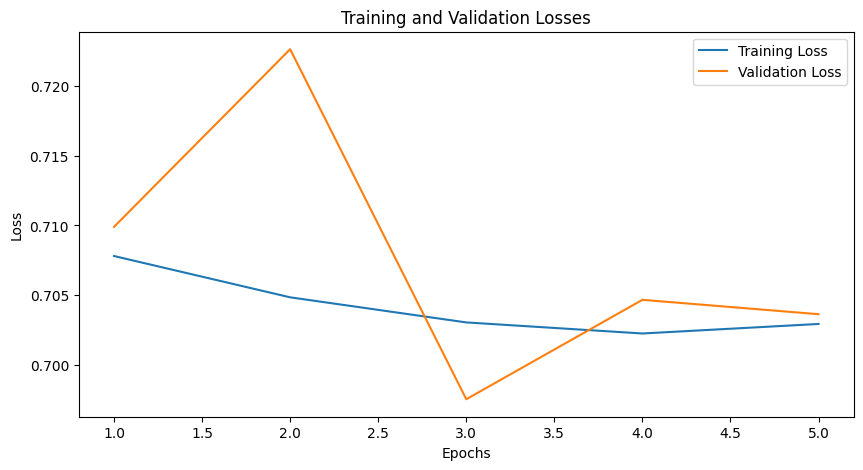

In [63]:
# plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

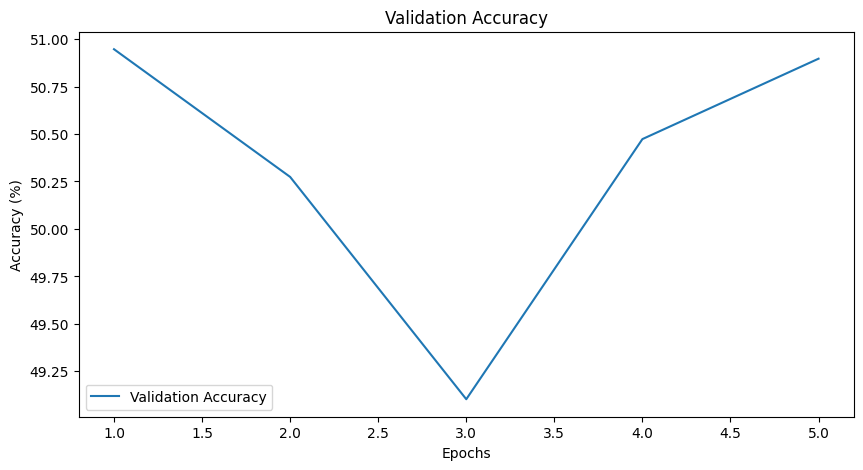

In [64]:
# plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), val_accuracy, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [65]:
# find the classification accuracy on test set
correct = 0
total = 0
with torch.no_grad():
    for input_batch, output_batch in tqdm(test_dataloader, total=len(test_dataloader), desc="Testing"):
        input_batch, output_batch = input_batch.to(device), output_batch.to(device)

        # Forward pass
        outputs = model(input_batch)

        # Get predicted labels
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += output_batch.size(0)

        # Total correct predictions
        correct += (predicted == output_batch).sum().item()

# Test accuracy
test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Testing: 100%|██████████| 628/628 [00:03<00:00, 192.34it/s]

Test Accuracy: 50.66%


#### 1.2 Incorporate stemming/lemmatization when doing text preprocessing using the NLTK library. What changes do you observe in accuracy ?

In [7]:
import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

# Now you can import the NLTK resources as usual
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

In [8]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('wordnet')

def clean_updated(text, tokenizer, lemmatizer):
    # Perform text preprocessing:
    # 1. Removing numbers OR replace them with "num" token
    # 2. Convert all characters to lowercase.
    # 3. Tokenize the sentence into words
    # 4. Perform lemmatization on each token
    # 5. Remove stopwords
    
    # You can use RegexpTokenizer from NLTK.

    text = re.sub(r'\d+', 'num', text)  # Replace numbers with "num"
    text = text.lower()  # Convert to lowercase
    tokens = tokenizer.tokenize(text)  # Tokenize
    
    # Perform lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    return tokens

tokenizer = RegexpTokenizer(r'\w+')  # Tokenizer
lemmatizer = WordNetLemmatizer()  # Lemmatizer

# Test the clean function
clean_updated("This IS 1 example sentence", tokenizer, lemmatizer)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['num', 'example', 'sentence']

In [9]:
# create a word to index dictionary so that each word in the training set
# has a number associated with it. This allows to represent each sentence
# as a series of numbers. Start the index with 1 instead of 0. The number
# 0 will be used to denote padding, so that each sentence can have the
# same length.
# Keep track of the index since it will be used for representing new words
# that were not part of the training vocabulary.
# Also, make sure to not create dictionary on sentences with word count
# not within the range

def get_word2idx(corpus, tokenizer, minlen=100, maxlen=500):
    word2idx = {}
    idx = 1
    for example in tqdm(corpus, total=len(corpus), desc="Creating word2idx"):
        # Extract text from example
        text = example["text"]

        # process sentence
        tokens = clean_updated(text, tokenizer, lemmatizer)

        # drop sentences greater than maxlen or less than minlen
        if len(tokens) < minlen or len(tokens) > maxlen:
            continue

        for token in tokens:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1

    return idx, word2idx

vocab_size, word2idx = get_word2idx(imdb_dataset["train"], tokenizer)

Creating word2idx: 100%|██████████| 25000/25000 [00:45<00:00, 553.62it/s]


In [10]:
# Build a Dataset object to store each sentence as a tensor of numbers
# along with the label. Make sure to add padding so that the tensor
# for each sentence is of the same length. This will allow us to train
# the model in batches.

class IMDBDataset(Dataset):
    def __init__(self, dataset, word2idx, split: str, minlen=100, maxlen=500):
        self.count = 0  # total sentences you finally pick

        # count total number of lines
        self.len = len(dataset[split])

        input_data = []
        target_data = []

        for idx, example in tqdm(enumerate(dataset[split]), total=self.len, desc=f"Transforming input text [{split}]"):
            # Extract text from example
            text = example["text"]

            # process sentence
            tokens = clean_updated(text, tokenizer, lemmatizer)

            # drop sentences greater than maxlen or less than minlen
            if len(tokens) < minlen or len(tokens) > maxlen:
                continue

            # replace words with their index
            indexed_tokens = [word2idx[token] for token in tokens if token in word2idx]
            input_data.append(torch.tensor(indexed_tokens))
            target_data.append(example["label"])

            self.count += 1

        # pad the sentences up to maxlen
        self.inputs = pad_sequence(input_data, batch_first=True)
        self.targets = torch.tensor(target_data)

    def __len__(self) -> int:
        return self.count

    def __getitem__(self, index: int):
        return self.inputs[index], self.targets[index]

In [11]:
from torch.utils.data import random_split


# create the train dataset using the word2idx dictionary built using the train set
train_ds = IMDBDataset(imdb_dataset, word2idx, "train", minlen=100, maxlen=500)

# create the validation and test dataset using the word2idx dictionary built using the train set

# Define the length of training and validation sets
total_length = len(train_ds)
train_length = int(0.8 * total_length)
val_length = total_length - train_length

# Split the training dataset
train_ds, val_ds = random_split(train_ds, [train_length, val_length])
test_ds = IMDBDataset(imdb_dataset, word2idx, "test", minlen=100, maxlen=500)

Transforming input text [test]: 100%|██████████| 25000/25000 [00:46<00:00, 541.66it/s]


In [12]:
# create dataloaders using the dataset
params = {
    'batch_size':32,
    'shuffle': True,
    'num_workers': 2
}

train_dataloader = DataLoader(train_ds, **params)
val_dataloader = DataLoader(val_ds, **params)
test_dataloader = DataLoader(test_ds, **params)

In [72]:
# create a model
class RNNModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, X):
        embedded = self.embedding(X)
        output, _ = self.rnn(embedded)
        logits = self.fc(output[:, -1, :])  # Pick the last output
        return logits

In [73]:
# Hyperparameters
hidden_size = 256
embedding_dim = 128
learning_rate = 1e-3
epochs = 5
num_classes = 2  # binary classification

# create the model
model = RNNModel(vocab_size, hidden_size, embedding_dim, num_classes).to(device)

# create optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(model)

RNNModel(
  (embedding): Embedding(56715, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [74]:
# train the model
train_losses, val_losses, val_accuracy = train_model(model, train_dataloader, val_dataloader, optimizer, epochs)

Epoch 1/5, Validation: 100%|██████████| 72/72 [00:00<00:00, 154.47it/s]


Epoch 1/5, Training Loss: 0.7152, Validation Loss: 0.7189, Validation Accuracy: 48.46%


Epoch 2/5, Validation: 100%|██████████| 72/72 [00:00<00:00, 155.84it/s]


Epoch 2/5, Training Loss: 0.7086, Validation Loss: 0.6938, Validation Accuracy: 49.98%


Epoch 3/5, Validation: 100%|██████████| 72/72 [00:00<00:00, 156.94it/s]


Epoch 3/5, Training Loss: 0.7060, Validation Loss: 0.7080, Validation Accuracy: 50.98%


Epoch 4/5, Validation: 100%|██████████| 72/72 [00:00<00:00, 145.83it/s]


Epoch 4/5, Training Loss: 0.7025, Validation Loss: 0.6994, Validation Accuracy: 49.33%


Epoch 5/5, Validation: 100%|██████████| 72/72 [00:00<00:00, 158.30it/s]

Epoch 5/5, Training Loss: 0.7051, Validation Loss: 0.7171, Validation Accuracy: 49.54%


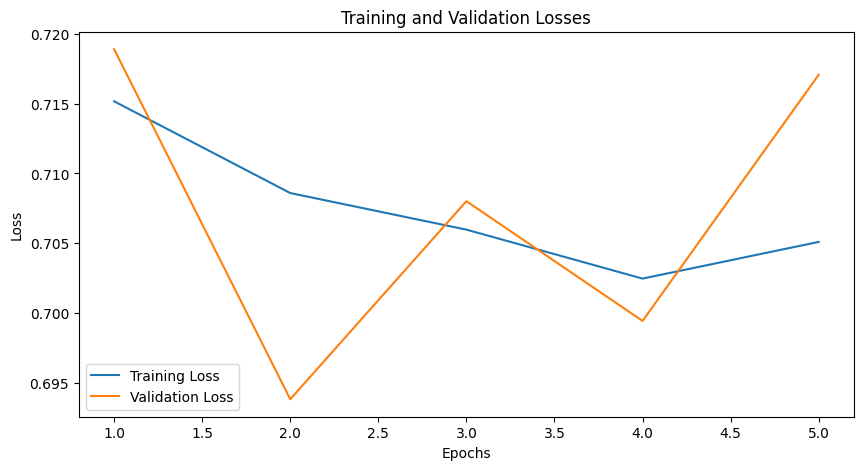

In [75]:
# plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

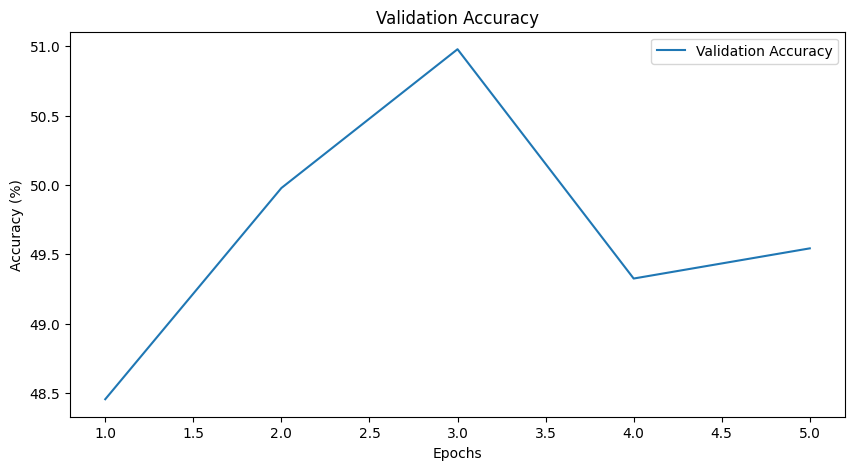

In [76]:
# plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), val_accuracy, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [77]:
# Test the model
test_accuracy = test_model(model, test_dataloader)

Testing: 100%|██████████| 352/352 [00:01<00:00, 180.32it/s]

Test Accuracy: 50.97%


#### 1.3 In the Model class, experiment with only picking the last output and mean of all outputs in the RNN layer. What changes do you observe ?

In [13]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes, output_mode='last'):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.output_mode = output_mode

    def forward(self, X):
        embedded = self.embedding(X)
        output, _ = self.rnn(embedded)
        
#         if self.output_mode == 'last':
#             output = output[:, -1, :]  # Pick the last output
#         elif self.output_mode == 'mean':
        output = torch.mean(output, dim=1)  # Take the mean of all outputs
        
        logits = self.fc(output)
        return logits

In [14]:
# Hyperparameters
hidden_size = 256
embedding_dim = 128
learning_rate = 1e-3
epochs = 5
num_classes = 2  # binary classification

# create the model
model = RNNModel(vocab_size, hidden_size, embedding_dim, num_classes).to(device)

# create optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(model)

RNNModel(
  (embedding): Embedding(56715, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [18]:
# train the model
train_losses, val_losses, val_accuracy = train_model(model, train_dataloader, val_dataloader, optimizer, epochs)

Epoch 1/5, Validation: 100%|██████████| 72/72 [00:00<00:00, 162.92it/s]


Epoch 1/5, Training Loss: 0.6953, Validation Loss: 0.6961, Validation Accuracy: 53.11%


Epoch 2/5, Validation: 100%|██████████| 72/72 [00:00<00:00, 161.89it/s]


Epoch 2/5, Training Loss: 0.6158, Validation Loss: 0.5247, Validation Accuracy: 76.29%


Epoch 3/5, Validation: 100%|██████████| 72/72 [00:00<00:00, 155.05it/s]


Epoch 3/5, Training Loss: 0.4782, Validation Loss: 0.5533, Validation Accuracy: 75.38%


Epoch 4/5, Validation: 100%|██████████| 72/72 [00:00<00:00, 159.07it/s]


Epoch 4/5, Training Loss: 0.3725, Validation Loss: 0.4276, Validation Accuracy: 81.47%


Epoch 5/5, Validation: 100%|██████████| 72/72 [00:00<00:00, 159.43it/s]

Epoch 5/5, Training Loss: 0.2909, Validation Loss: 0.3906, Validation Accuracy: 83.43%


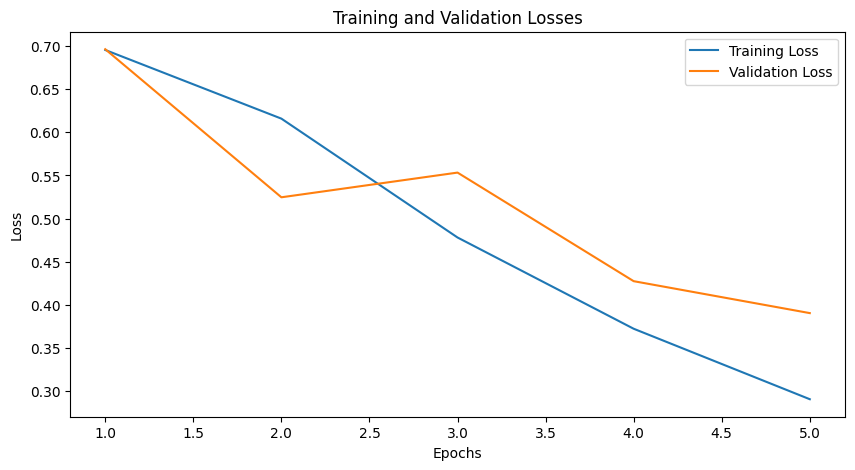

In [19]:
# plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

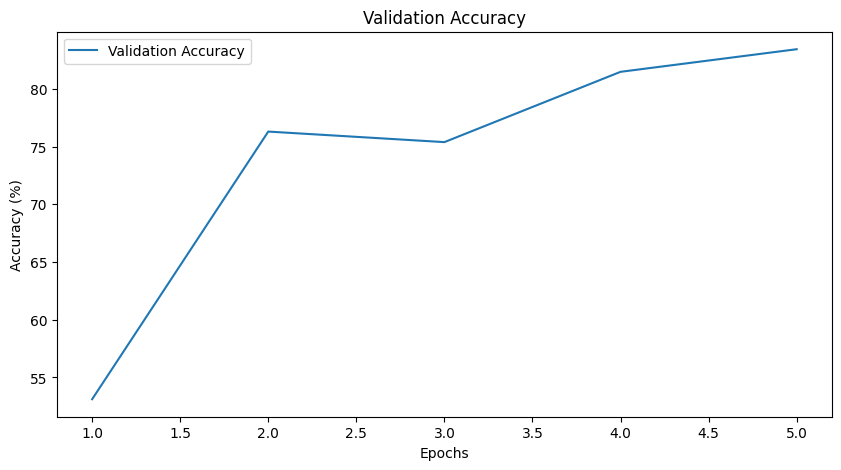

In [20]:
# plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), val_accuracy, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [21]:
# Test the model
test_accuracy = test_model(model, test_dataloader)

Testing: 100%|██████████| 352/352 [00:01<00:00, 184.37it/s]

Test Accuracy: 79.93%


### 2. Hyperparameter Tuning
#### 2.1 Starting with the best configurations based on the above experiments, experiment with 5 different hyperparameter configurations. You can change the size of embedding layer, hidden state, batch in the dataloader.


In [22]:
def train_with_hyperparameters(embedding_dim, hidden_size, batch_size, epochs):
    # Create the RNN model with the specified hyperparameters
    model = RNNModel(vocab_size, hidden_size, embedding_dim, num_classes, output_mode='last').to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    # Create dataloaders with the specified batch size
    train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    val_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
    
    # Train the model
    train_losses, val_losses, val_accuracy = train_model(model, train_dataloader, val_dataloader, optimizer, epochs)
    
    return train_losses, val_losses, val_accuracy

In [23]:
def evaluate_model(train_losses, val_losses, val_accuracy):
    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), val_accuracy, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

    # Test the model
    test_accuracy = test_model(model, test_dataloader)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    return test_accuracy

Training Model with Hyperparameters - Configuration 1
Embedding Dimension: 128, Hidden Size: 256, Batch Size: 32


Epoch 1/5, Validation: 100%|██████████| 72/72 [00:00<00:00, 161.19it/s]


Epoch 1/5, Training Loss: 0.6892, Validation Loss: 0.6222, Validation Accuracy: 61.77%


Epoch 2/5, Validation: 100%|██████████| 72/72 [00:00<00:00, 159.87it/s]


Epoch 2/5, Training Loss: 0.6233, Validation Loss: 0.6591, Validation Accuracy: 70.16%


Epoch 3/5, Validation: 100%|██████████| 72/72 [00:00<00:00, 157.72it/s]


Epoch 3/5, Training Loss: 0.5859, Validation Loss: 0.6539, Validation Accuracy: 59.07%


Epoch 4/5, Validation: 100%|██████████| 72/72 [00:00<00:00, 156.71it/s]


Epoch 4/5, Training Loss: 0.4693, Validation Loss: 0.4699, Validation Accuracy: 78.86%


Epoch 5/5, Validation: 100%|██████████| 72/72 [00:00<00:00, 162.24it/s]


Epoch 5/5, Training Loss: 0.5148, Validation Loss: 0.6043, Validation Accuracy: 77.99%


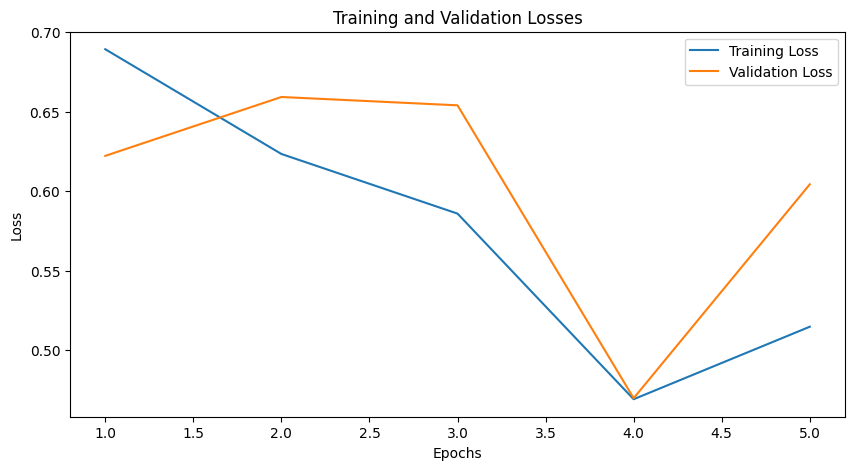

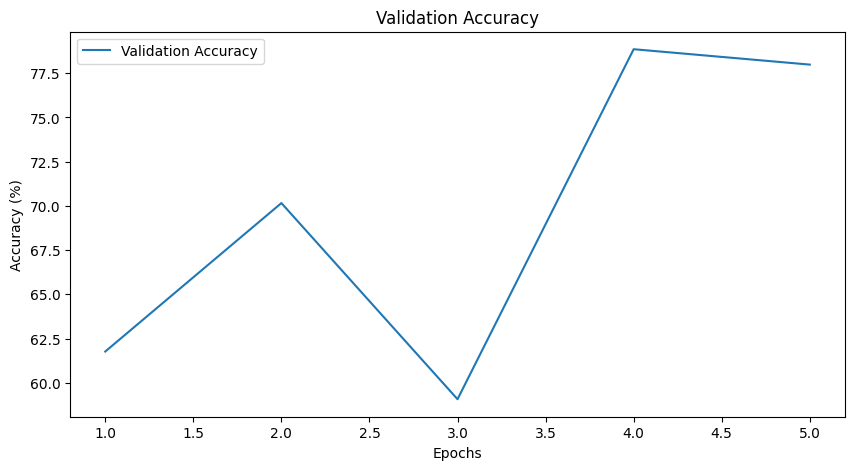

Testing: 100%|██████████| 352/352 [00:01<00:00, 187.61it/s]


Test Accuracy: 79.93%
Test Accuracy: 79.93%
Training Model with Hyperparameters - Configuration 2
Embedding Dimension: 256, Hidden Size: 512, Batch Size: 64


Epoch 1/5, Validation: 100%|██████████| 36/36 [00:00<00:00, 52.45it/s]


Epoch 1/5, Training Loss: 0.6912, Validation Loss: 0.6623, Validation Accuracy: 63.20%


Epoch 2/5, Validation: 100%|██████████| 36/36 [00:00<00:00, 52.18it/s]


Epoch 2/5, Training Loss: 0.6917, Validation Loss: 0.6998, Validation Accuracy: 56.24%


Epoch 3/5, Validation: 100%|██████████| 36/36 [00:00<00:00, 52.02it/s]


Epoch 3/5, Training Loss: 0.6942, Validation Loss: 0.7724, Validation Accuracy: 44.72%


Epoch 4/5, Validation: 100%|██████████| 36/36 [00:00<00:00, 52.65it/s]


Epoch 4/5, Training Loss: 0.7091, Validation Loss: 0.6912, Validation Accuracy: 51.33%


Epoch 5/5, Validation: 100%|██████████| 36/36 [00:00<00:00, 52.42it/s]


Epoch 5/5, Training Loss: 0.6920, Validation Loss: 0.6774, Validation Accuracy: 62.46%


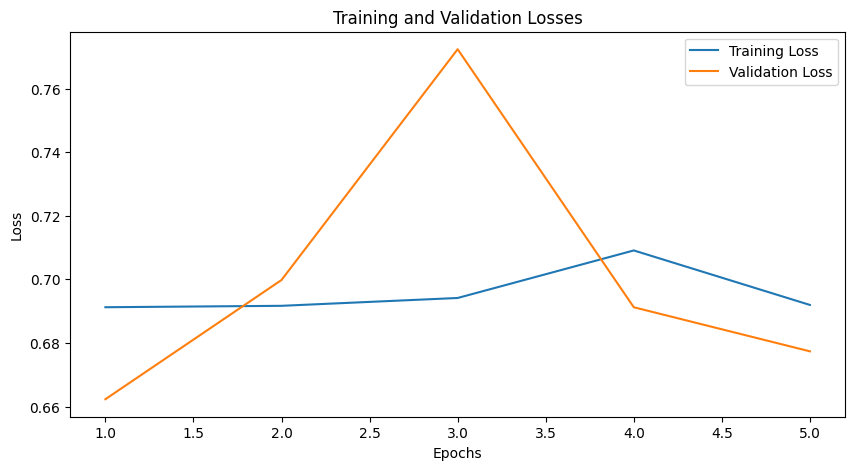

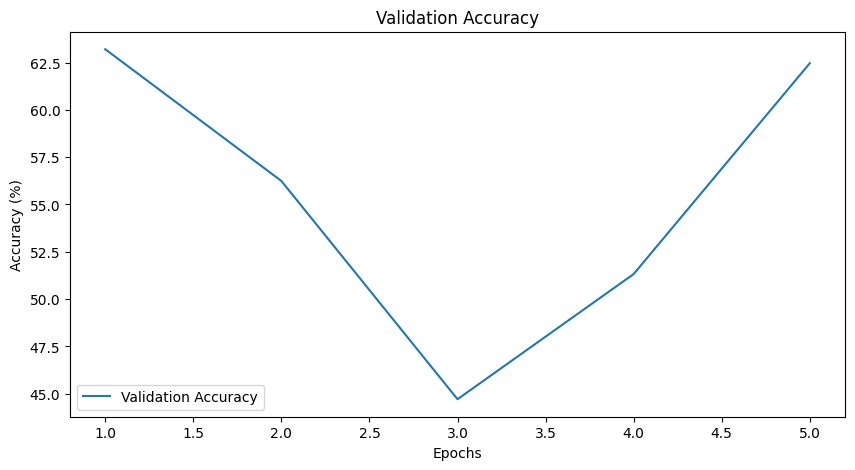

Testing: 100%|██████████| 352/352 [00:01<00:00, 186.21it/s]


Test Accuracy: 79.93%
Test Accuracy: 79.93%
Training Model with Hyperparameters - Configuration 3
Embedding Dimension: 64, Hidden Size: 128, Batch Size: 16


Epoch 1/5, Validation: 100%|██████████| 144/144 [00:00<00:00, 271.80it/s]


Epoch 1/5, Training Loss: 0.6946, Validation Loss: 0.6859, Validation Accuracy: 54.81%


Epoch 2/5, Validation: 100%|██████████| 144/144 [00:00<00:00, 252.98it/s]


Epoch 2/5, Training Loss: 0.6739, Validation Loss: 0.5312, Validation Accuracy: 76.95%


Epoch 3/5, Validation: 100%|██████████| 144/144 [00:00<00:00, 287.92it/s]


Epoch 3/5, Training Loss: 0.6369, Validation Loss: 0.6339, Validation Accuracy: 78.34%


Epoch 4/5, Validation: 100%|██████████| 144/144 [00:00<00:00, 284.00it/s]


Epoch 4/5, Training Loss: 0.4504, Validation Loss: 0.4062, Validation Accuracy: 82.51%


Epoch 5/5, Validation: 100%|██████████| 144/144 [00:00<00:00, 293.64it/s]


Epoch 5/5, Training Loss: 0.2736, Validation Loss: 0.4135, Validation Accuracy: 82.91%


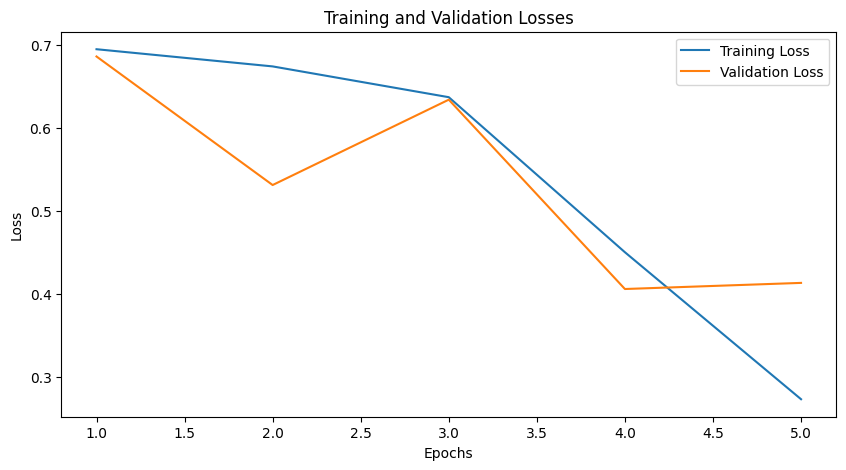

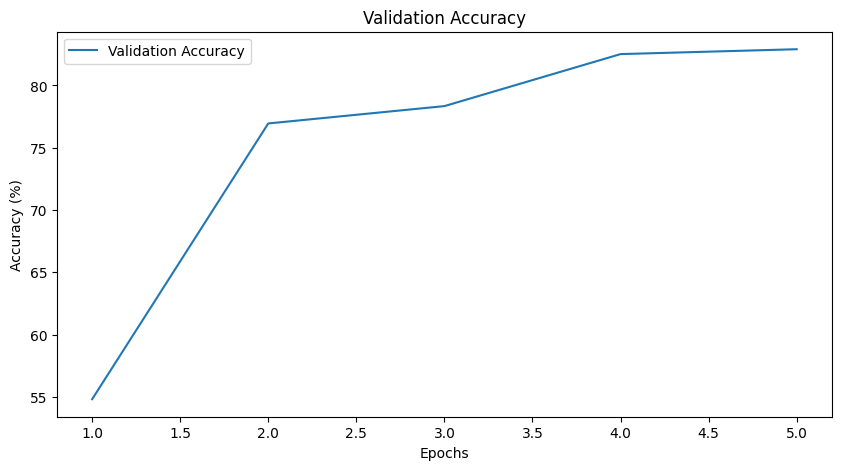

Testing: 100%|██████████| 352/352 [00:01<00:00, 191.52it/s]


Test Accuracy: 79.93%
Test Accuracy: 79.93%
Training Model with Hyperparameters - Configuration 4
Embedding Dimension: 128, Hidden Size: 256, Batch Size: 64


Epoch 1/5, Validation: 100%|██████████| 36/36 [00:00<00:00, 99.77it/s] 


Epoch 1/5, Training Loss: 0.6918, Validation Loss: 0.6705, Validation Accuracy: 55.85%


Epoch 2/5, Validation: 100%|██████████| 36/36 [00:00<00:00, 97.92it/s] 


Epoch 2/5, Training Loss: 0.6317, Validation Loss: 0.5875, Validation Accuracy: 73.08%


Epoch 3/5, Validation: 100%|██████████| 36/36 [00:00<00:00, 99.11it/s] 


Epoch 3/5, Training Loss: 0.6311, Validation Loss: 0.6183, Validation Accuracy: 77.16%


Epoch 4/5, Validation: 100%|██████████| 36/36 [00:00<00:00, 100.34it/s]


Epoch 4/5, Training Loss: 0.4834, Validation Loss: 0.4523, Validation Accuracy: 79.12%


Epoch 5/5, Validation: 100%|██████████| 36/36 [00:00<00:00, 95.05it/s] 


Epoch 5/5, Training Loss: 0.3333, Validation Loss: 0.4453, Validation Accuracy: 81.82%


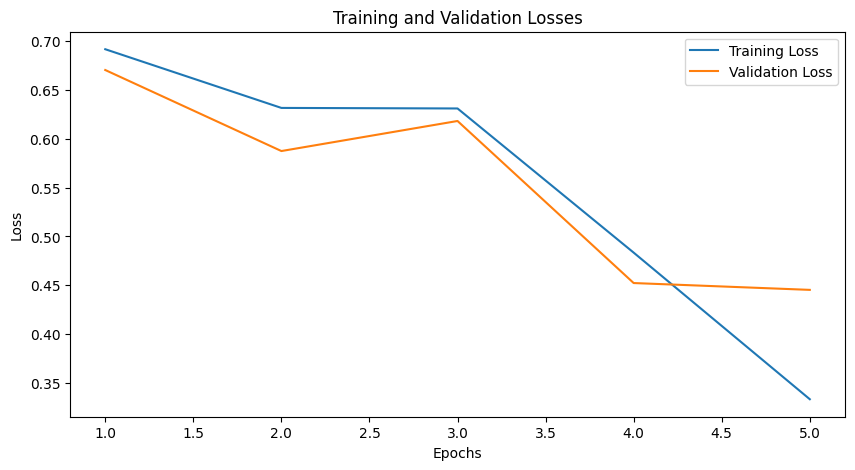

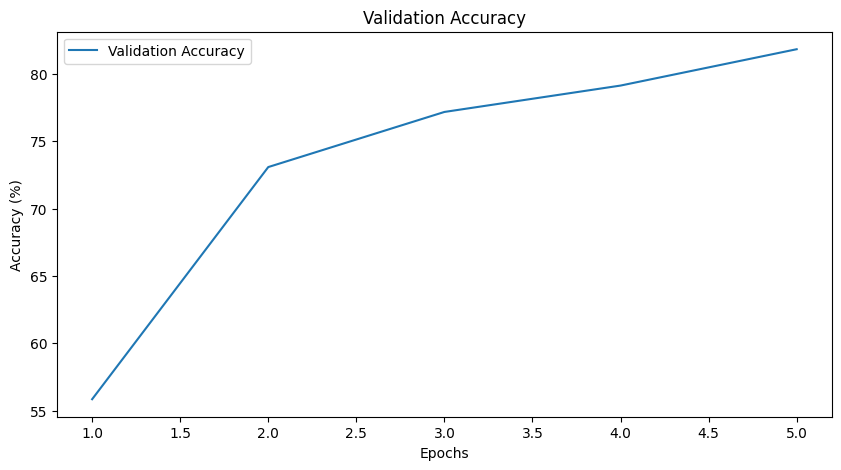

Testing: 100%|██████████| 352/352 [00:01<00:00, 189.90it/s]


Test Accuracy: 79.93%
Test Accuracy: 79.93%
Training Model with Hyperparameters - Configuration 5
Embedding Dimension: 256, Hidden Size: 512, Batch Size: 128


Epoch 1/5, Validation: 100%|██████████| 18/18 [00:00<00:00, 34.27it/s]


Epoch 1/5, Training Loss: 0.7137, Validation Loss: 0.6397, Validation Accuracy: 63.33%


Epoch 2/5, Validation: 100%|██████████| 18/18 [00:00<00:00, 35.14it/s]


Epoch 2/5, Training Loss: 0.6137, Validation Loss: 0.6342, Validation Accuracy: 74.64%


Epoch 3/5, Validation: 100%|██████████| 18/18 [00:00<00:00, 35.29it/s]


Epoch 3/5, Training Loss: 0.6090, Validation Loss: 0.5359, Validation Accuracy: 74.03%


Epoch 4/5, Validation: 100%|██████████| 18/18 [00:00<00:00, 35.11it/s]


Epoch 4/5, Training Loss: 0.4001, Validation Loss: 0.4255, Validation Accuracy: 81.86%


Epoch 5/5, Validation: 100%|██████████| 18/18 [00:00<00:00, 35.24it/s]


Epoch 5/5, Training Loss: 0.2644, Validation Loss: 0.3936, Validation Accuracy: 83.21%


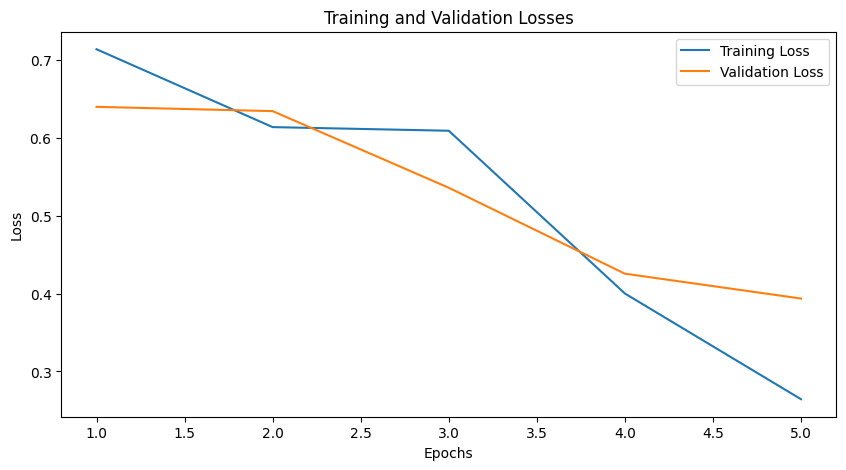

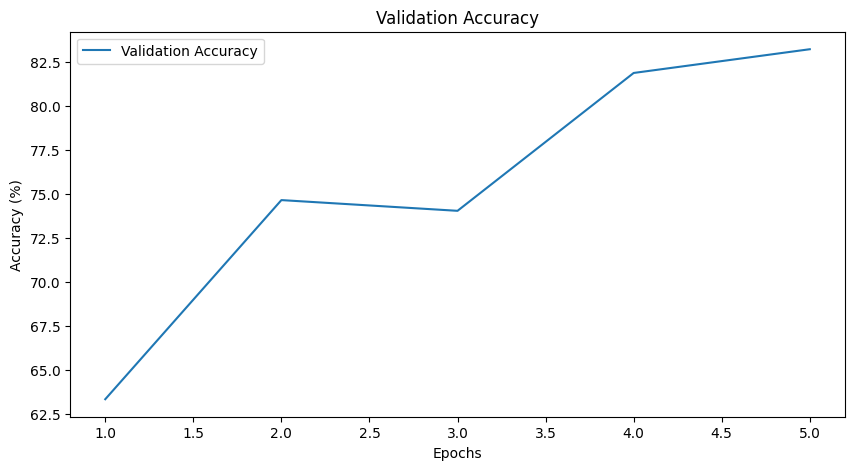

Testing: 100%|██████████| 352/352 [00:01<00:00, 186.66it/s]

Test Accuracy: 79.93%
Test Accuracy: 79.93%


In [24]:
hyperparameters = [
    (128, 256, 32),   # embedding_dim, hidden_size, batch_size (Configuration 1)
    (256, 512, 64),   # embedding_dim, hidden_size, batch_size (Configuration 2)
    (64, 128, 16),    # embedding_dim, hidden_size, batch_size (Configuration 3)
    (128, 256, 64),   # embedding_dim, hidden_size, batch_size (Configuration 4)
    (256, 512, 128)   # embedding_dim, hidden_size, batch_size (Configuration 5)
]

results = []

for idx, (embedding_dim, hidden_size, batch_size) in enumerate(hyperparameters, start=1):
    print(f"Training Model with Hyperparameters - Configuration {idx}")
    print(f"Embedding Dimension: {embedding_dim}, Hidden Size: {hidden_size}, Batch Size: {batch_size}")
    
    train_losses, val_losses, val_accuracy = train_with_hyperparameters(embedding_dim, hidden_size, batch_size, epochs)
    
    test_accuracy = evaluate_model(train_losses, val_losses, val_accuracy)
    
    results.append({
        'configuration': idx,
        'embedding_dim': embedding_dim,
        'hidden_size': hidden_size,
        'batch_size': batch_size,
        'test_accuracy': test_accuracy
    })


In [25]:
results

[{'configuration': 1,
  'embedding_dim': 128,
  'hidden_size': 256,
  'batch_size': 32,
  'test_accuracy': 79.92713701794918},
 {'configuration': 2,
  'embedding_dim': 256,
  'hidden_size': 512,
  'batch_size': 64,
  'test_accuracy': 79.92713701794918},
 {'configuration': 3,
  'embedding_dim': 64,
  'hidden_size': 128,
  'batch_size': 16,
  'test_accuracy': 79.92713701794918},
 {'configuration': 4,
  'embedding_dim': 128,
  'hidden_size': 256,
  'batch_size': 64,
  'test_accuracy': 79.92713701794918},
 {'configuration': 5,
  'embedding_dim': 256,
  'hidden_size': 512,
  'batch_size': 128,
  'test_accuracy': 79.92713701794918}]

### 3. After RNNs
#### 3.1 Keeping all the parameters same, replace the RNN layer with the LSTM layer using nn.LSTM. What changes do you observe ? Explain why LSTM layer would affect performance.

In [30]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes, output_mode='last'):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.output_mode = output_mode

    def forward(self, X):
        embedded = self.embedding(X)
        output, _ = self.lstm(embedded)
        
#         if self.output_mode == 'last':
#             output = output[:, -1, :]  # Pick the last output
#         elif self.output_mode == 'mean':
        output = torch.mean(output, dim=1)  # Take the mean of all outputs
        
        logits = self.fc(output)
        return logits

In [31]:
def train_lstm_model(model, train_dataloader, val_dataloader, optimizer, epochs):
    train_losses = []
    val_losses = []
    val_accuracy = []
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        ## TRAINING STEP
        model.train()
        epoch_train_losses = []
        for input_batch, output_batch in tqdm(train_dataloader, total=len(train_dataloader), desc=f"Epoch {epoch+1}/{epochs}, Training"):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            output = model(input_batch)
            
            # Compute the loss
            loss = criterion(output, output_batch)
            epoch_train_losses.append(loss.item())
            
            # Backward pass
            loss.backward()
            
            # Optimize
            optimizer.step()
            
        # Calculate average training loss for the epoch
        train_loss = np.mean(epoch_train_losses)
        train_losses.append(train_loss)
        
        ## VALIDATION STEP
        model.eval()
        epoch_val_losses = []
        correct = 0
        total = 0
        with torch.no_grad():
            for input_batch, output_batch in tqdm(val_dataloader, total=len(val_dataloader), desc=f"Epoch {epoch+1}/{epochs}, Validation"):
                input_batch, output_batch = input_batch.to(device), output_batch.to(device)
                
                # Forward pass
                output = model(input_batch)
                
                # Compute the loss
                val_loss = criterion(output, output_batch)
                epoch_val_losses.append(val_loss.item())
                
                # Calculate accuracy
                _, predicted = torch.max(output.data, 1)
                total += output_batch.size(0)
                correct += (predicted == output_batch).sum().item()
                
        # Calculate average validation loss for the epoch
        val_loss = np.mean(epoch_val_losses)
        val_losses.append(val_loss)
        
        # Calculate validation accuracy
        accuracy = 100 * correct / total
        val_accuracy.append(accuracy)
        
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")
    
    return train_losses, val_losses, val_accuracy


Epoch 1/5, Validation: 100%|██████████| 72/72 [00:01<00:00, 36.41it/s]


Epoch 1/5, Training Loss: 0.6903, Validation Loss: 0.6773, Validation Accuracy: 56.55%


Epoch 2/5, Validation: 100%|██████████| 72/72 [00:01<00:00, 36.49it/s]


Epoch 2/5, Training Loss: 0.6046, Validation Loss: 0.4849, Validation Accuracy: 77.51%


Epoch 3/5, Validation: 100%|██████████| 72/72 [00:01<00:00, 36.19it/s]


Epoch 3/5, Training Loss: 0.3257, Validation Loss: 0.3600, Validation Accuracy: 85.56%


Epoch 4/5, Validation: 100%|██████████| 72/72 [00:01<00:00, 36.53it/s]


Epoch 4/5, Training Loss: 0.1669, Validation Loss: 0.3757, Validation Accuracy: 86.12%


Epoch 5/5, Validation: 100%|██████████| 72/72 [00:01<00:00, 36.57it/s]


Epoch 5/5, Training Loss: 0.0733, Validation Loss: 0.4299, Validation Accuracy: 84.30%


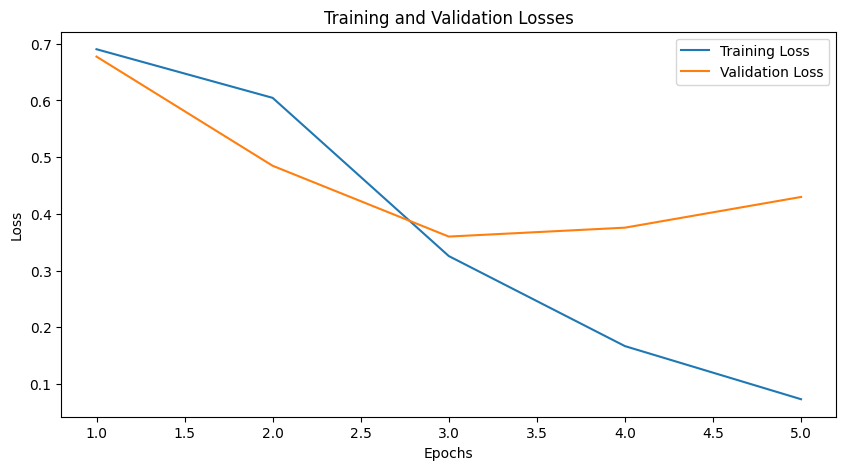

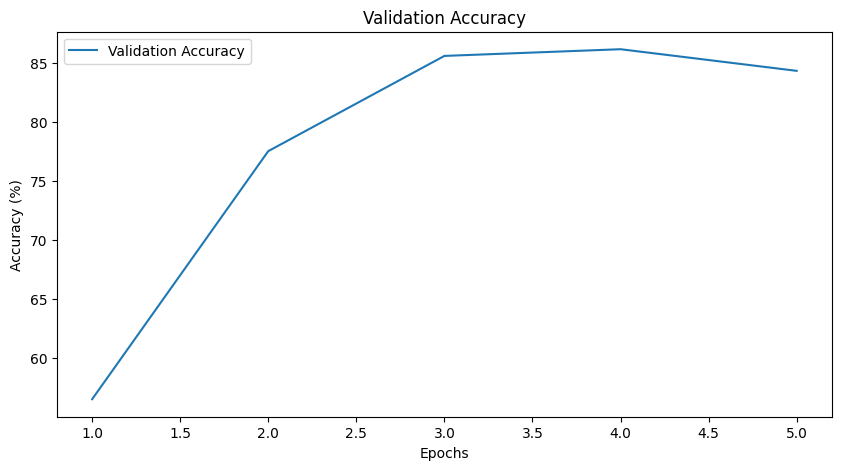

Testing: 100%|██████████| 352/352 [00:01<00:00, 184.84it/s]

Test Accuracy: 79.93%
Test Accuracy: 79.93%


79.92713701794918

In [32]:
# Create the LSTM model
lstm_model = LSTMModel(vocab_size, hidden_size, embedding_dim, num_classes, output_mode='last').to(device)

# Create optimizer
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=learning_rate)

# Train the LSTM model
train_losses_lstm, val_losses_lstm, val_accuracy_lstm = train_lstm_model(lstm_model, train_dataloader, val_dataloader, optimizer_lstm, epochs)

# Evaluate the LSTM model
evaluate_model(train_losses_lstm, val_losses_lstm, val_accuracy_lstm)
